# Code example
- **Generating the sequence of requests based on a list of past executions**
- **Computing the cost of a sequence for new executions**

Input data is represented by:
 * An array of past execution times

Default case (no parameters are set)
- Computes the sequence using Distribution Interpolation if the array of past executions has less than 100 entries
- Computes the sequence using discrete data otherwise
- Assumes the application cannot be checkpointed

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import random

import sys
sys.path.append("..")
import iSBatch

# Read input data

Input data should be an array with each element representing one execution

In [3]:
dataset = "./logs/truncnorm.in"
data = np.loadtxt(dataset, delimiter=' ')
#data = [int(i/100) for i in data]
print("Total entries in the historic data: %d" %(len(data)))

Total entries in the historic data: 1000


# Compute the discrete CDF

Compute the discrete CDF, it's cost on the same data (optimal cost), compute the sequence and plot them

In [4]:
# Optimal CDF by using the discrete full data both for computing the data and for computing the cost
wf = iSBatch.ResourceEstimator(data)
optimal_data, optimal_cdf = wf._get_cdf()

optimal_sequence = wf.compute_request_sequence()
print("Optimal sequence", optimal_sequence)

optimal_cost = wf.compute_sequence_cost(optimal_sequence, data)
print("Optimal cost", optimal_cost)

Optimal sequence [(11.215230398339102, 0), (13.33928544239686, 0)]
Optimal cost 20.42638202879111


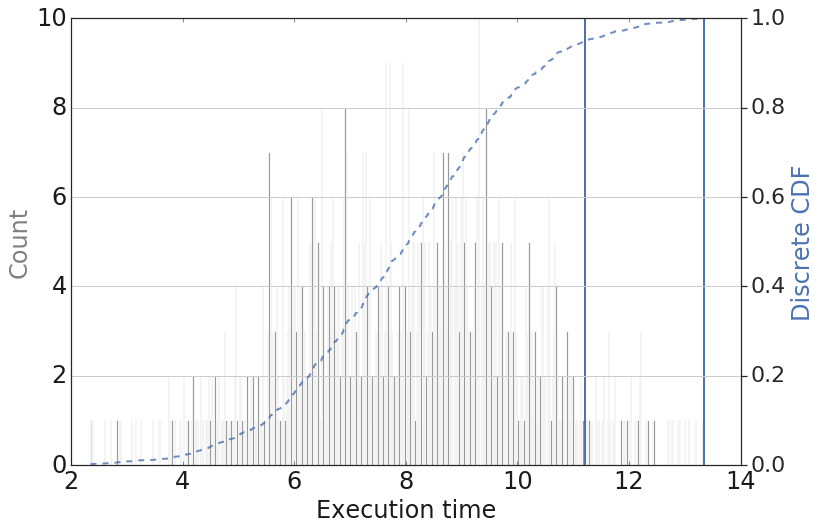

In [5]:
# plot the data and the discrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot sequence
ax.vlines(optimal_sequence[0][0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i][0], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot discrete fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8)

plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF', color="b")
ax.set_ylabel('Count', color="grey")
plt.show()

# Interpolate the CDF with a distribution fit

- Overwrite the default that uses discrete for logs bigger than 100 elements

In [6]:
# force Interpolation fit
wf = iSBatch.ResourceEstimator(
    data, interpolation_model=iSBatch.DistInterpolation())

In [7]:
all_data_discrete, all_data_cdf = wf._get_cdf()
best_fit = wf._get_best_fit()
distr_sequence = wf.compute_request_sequence()
print("Distribution sequence", distr_sequence)

Distribution sequence [(11.511610777571594, 0), (13.33928544239686, 0)]


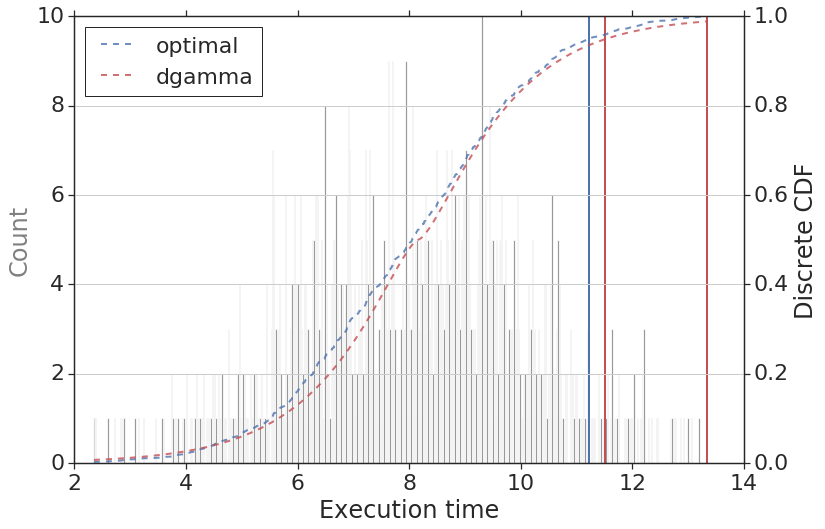

In [8]:
# plot the data and the interpolation CDF

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot optimal sequence
ax.vlines(optimal_sequence[0][0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i][0], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0][0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i][0], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.legend(loc='upper left')
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="grey")
#plt.savefig("docs/sequence.png")
plt.show()

# Use only the first x entries in data for interpolation

In [9]:
# define x
training_size = 10

In [10]:
# the training data must include the max expected execution time
training_data = random.sample(list(data), training_size) + [max(data)]

# force to use discrete CDF
wf = iSBatch.ResourceEstimator(training_data, interpolation_model=[])
discret_data, cdf = wf._get_cdf()

discrete_sequence = wf.compute_request_sequence()
print("Discrete sequence", discrete_sequence)
print("Discrete cost", wf.compute_sequence_cost(discrete_sequence, data))

Discrete sequence [(10.064729161141432, 0), (13.33928544239686, 0)]
Discrete cost 21.630119735135178


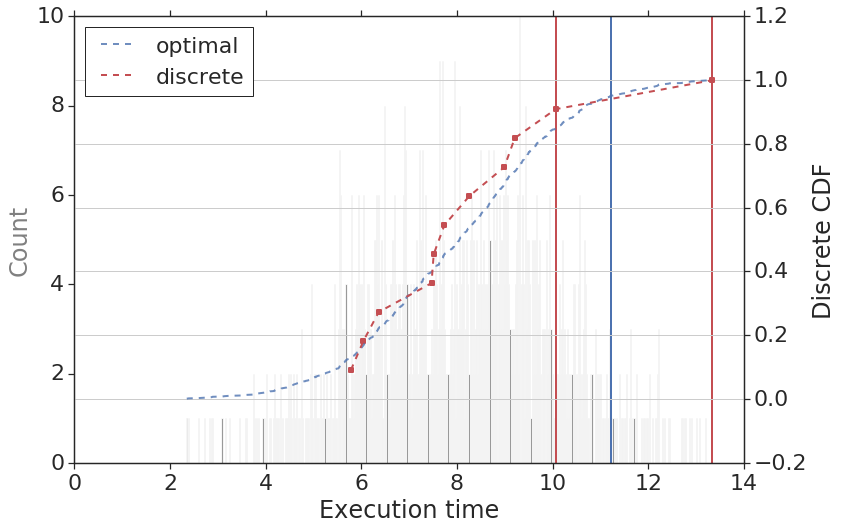

In [11]:
# plot the fit of the discrete fit (using the first x entries)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot optimal sequence
ax.vlines(optimal_sequence[0][0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i][0], min(counts), max(counts), colors='b', lw=2, linestyles='solid')


# plot the discrete sequence
ax.vlines(discrete_sequence[0][0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i][0], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# plot sample data
ax2.plot(discret_data + [max(data)], cdf + [1], 'r--', lw=2, alpha=1, label="discrete")
ax2.scatter(discret_data, cdf, marker="s", color="r", lw=2, alpha=1)

ax2.legend(shadow=True)
plt.legend(loc='upper left')
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="grey")
plt.show()

# Distribution interpolation

In [12]:
# compute the interpolation of the CDF points
wf = iSBatch.ResourceEstimator(training_data)
distr_sequence = wf.compute_request_sequence()

best_fit = wf._get_best_fit()
print(best_fit)
all_data_discrete, all_data_cdf = wf._get_cdf()

print("Distribution sequence", distr_sequence)
print("Distribution cost", wf.compute_sequence_cost(distr_sequence, data))

(<scipy.stats._continuous_distns.dgamma_gen object at 0x7fd10ed44908>, (1.4454421952866658, 8.021153661940488, 1.067288342423725), 2.6781889792248323)
Distribution sequence [(11.249553915688335, 0), (13.33928544239686, 0)]
Distribution cost 20.46238739849044


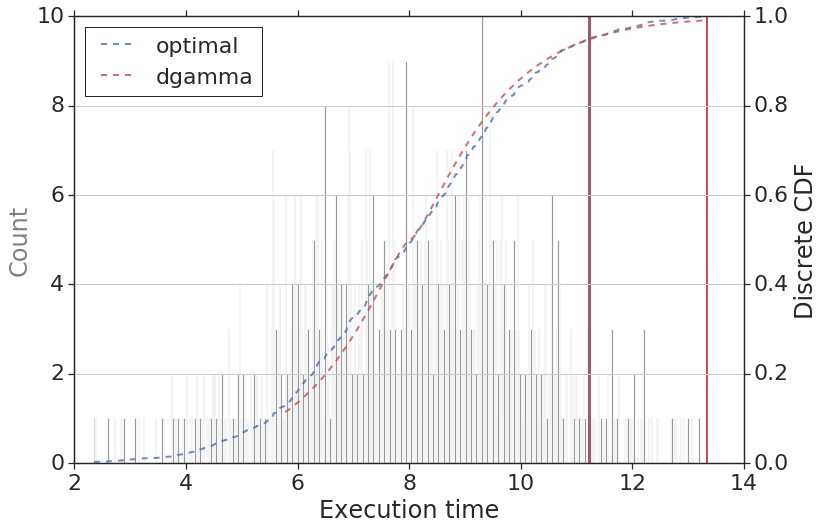

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot optimal sequence
ax.vlines(optimal_sequence[0][0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i][0], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0][0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i][0], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.legend(loc='upper left')
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="grey")
plt.show()